In [69]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from matplotlib.font_manager import FontProperties

In [70]:
class Seg(object):
    # https://www.ncbi.nlm.nih.gov/grc/human/data
    # Using "placed scaffolds" as operative metric
    genome = {
        1: 248_956_422,
        2: 242_193_529,
        3: 198_295_559,
        4: 190_214_555,
        5: 181_538_259,
        6: 170_805_979,
        7: 159_345_973,
        8: 145_138_636,
        9: 138_394_717,
        10: 133_797_422,
        11: 135_086_622,
        12: 133_275_309,
        13: 114_364_328,
        14: 107_043_718,
        15: 101_991_189,
        16: 90_338_345,
        17: 83_257_441,
        18: 80_373_285,
        19: 58_617_616,
        20: 64_444_167,
        21: 46_709_983,
        22: 50_818_468,
        'X': 156_040_895,
        'Y': 57_227_415  
    }
    
    def __init__(self, datadir, prefix):
        self.datadir = os.path.abspath(datadir)
        self.prefix = prefix
        
        self.cnaseg_path = os.path.join(datadir, f'{prefix}.cna.seg')
        self.seg_path = os.path.join(datadir, f'{prefix}.seg')
        
        self.cnaseg = pd.read_csv(self.cnaseg_path, sep='\t')
        self.cnaseg.columns = ['chr', 'start', 'end', 
                               'copy_num', 'event', 'logR', 
                               'subclone_status', 'corrected_copy_num', 
                               'corrected_call', 'logR_copy_num']
        self.seg = pd.read_csv(self.seg_path, sep='\t')
        self.seg.columns = ['sample', 'chr', 'start', 'end', 
                            'event', 'copy_num', 'bins', 'median']
    
    def get_genome_length(self, exclude = ['X', 'Y']):
        return sum([v for k, v in self.genome.items() if k not in exclude])
    
    # https://search.r-project.org/CRAN/refmans/CINmetrics/html/fga.html
    def calc_fga(self, exclude = ['X', 'Y']):
        self.cnaseg['win_length'] = self.cnaseg.end - self.cnaseg.start + 1
        self.cnaseg['altered'] = np.abs(self.cnaseg.logR) >= 0.2
        print(self.cnaseg['altered'])
        print( self.cnaseg['win_length'])
        altered_bp = self.cnaseg[self.cnaseg['altered']].win_length.sum()
        total_bp = self.get_genome_length(exclude = exclude)
        print(total_bp)
        print(total_bp)
        return altered_bp / total_bp
        
    
    # Dr. Tagore's R method
    # Issues:
    #  1) It's done on a per-chromosome basis
    #  2) It's done on the medians rather than the raw window values
    #  3) The thresholds are tied to the 5th and 95th percentile values so will inherently never be over 0.1
    def calc_fga_tagore(self, exclude = ['X', 'Y']):
        chroms = [k for k, v in self.genome.items() if k not in exclude]
        
        lower, upper = self.seg['median'].quantile([0.05, 0.95])
        
        chrom_altered = {}
        for chrom in chroms:
            subset = self.seg[(self.seg.chr == str(chrom)) & 
                                 ((self.seg['median'] > upper) | 
                                  (self.seg['median'] < lower))]
            chrom_altered[chrom] = (subset.end - subset.start + 1).sum() / self.genome[chrom]
        
        altered_bp = sum([v for k,v in chrom_altered.items()])
        total_bp = self.get_genome_length(exclude = exclude)
        
        return altered_bp / total_bp
        


In [71]:
all_samples = [
    'WGS/Sarcoma167_S130_L001/Sarcoma167_S130_L001',
    'WGS/Sarcoma322_S133_L001/Sarcoma322_S133_L001',
    'WGS/Sarcoma559_S132_L001/Sarcoma559_S132_L001',
    'WGS/Sarcoma708_S131_L001/Sarcoma708_S131_L001',
    'WGS/SarcomaS408_S121_L002/SarcomaS408_S121_L002',
    'WGS/SarcomaS410_S123_L002/SarcomaS410_S123_L002',
    'WGS/SarcomaS914_S120_L002/SarcomaS914_S120_L002',
    'WGS/SarcomaS956_S119_L002/SarcomaS956_S119_L002'
]
len(all_samples)
# Should be 42


8

In [72]:
fga_list = []
fga_list_tagore = []
for i, sample in enumerate(all_samples):
    fullname = f'{sample}_tumor'
    data = Seg('../data', fullname)
    fga = data.calc_fga()
    fga_tagore = data.calc_fga_tagore()
    
    fga_list.append(fga)
    fga_list_tagore.append(fga_tagore)
    
res = pd.DataFrame({'Sample': all_samples, 'FGA': fga_list, 'FGA_Tagore': fga_list_tagore}).sort_values('Sample')
res


res = res[['Sample', 'FGA', 'FGA_Tagore']]

res

0       False
1       False
2       False
3       False
4       False
        ...  
2481     True
2482    False
2483    False
2484    False
2485    False
Name: altered, Length: 2486, dtype: bool
0       1000000
1       1000000
2       1000000
3       1000000
4       1000000
         ...   
2481    1000000
2482    1000000
2483    1000000
2484    1000000
2485    1000000
Name: win_length, Length: 2486, dtype: int64
2875001522
2875001522
0       False
1       False
2       False
3        True
4        True
        ...  
2481    False
2482    False
2483    False
2484    False
2485    False
Name: altered, Length: 2486, dtype: bool
0       1000000
1       1000000
2       1000000
3       1000000
4       1000000
         ...   
2481    1000000
2482    1000000
2483    1000000
2484    1000000
2485    1000000
Name: win_length, Length: 2486, dtype: int64
2875001522
2875001522
0       False
1       False
2       False
3       False
4       False
        ...  
2481    False
2482    False
2483    Fals

,Sample,FGA,FGA_Tagore
0,WGS/Sarcoma167_S130_L001/Sarcoma167_S130_L001,0.415652,3.963925e-10
1,WGS/Sarcoma322_S133_L001/Sarcoma322_S133_L001,0.465391,3.773051e-10
2,WGS/Sarcoma559_S132_L001/Sarcoma559_S132_L001,0.103652,5.644722e-10
3,WGS/Sarcoma708_S131_L001/Sarcoma708_S131_L001,0.472348,2.410313e-10
4,WGS/SarcomaS408_S121_L002/SarcomaS408_S121_L002,0.263652,6.832193e-10
5,WGS/SarcomaS410_S123_L002/SarcomaS410_S123_L002,0.230609,6.209581e-10
6,WGS/SarcomaS914_S120_L002/SarcomaS914_S120_L002,0.471304,3.854911e-10
7,WGS/SarcomaS956_S119_L002/SarcomaS956_S119_L002,0.261217,6.856383e-10


In [73]:
res.index = ["167", "322", "559", "708", "S408", "S410", "S914", "S956"]
res

,Sample,FGA,FGA_Tagore
167,WGS/Sarcoma167_S130_L001/Sarcoma167_S130_L001,0.415652,3.963925e-10
322,WGS/Sarcoma322_S133_L001/Sarcoma322_S133_L001,0.465391,3.773051e-10
559,WGS/Sarcoma559_S132_L001/Sarcoma559_S132_L001,0.103652,5.644722e-10
708,WGS/Sarcoma708_S131_L001/Sarcoma708_S131_L001,0.472348,2.410313e-10
S408,WGS/SarcomaS408_S121_L002/SarcomaS408_S121_L002,0.263652,6.832193e-10
S410,WGS/SarcomaS410_S123_L002/SarcomaS410_S123_L002,0.230609,6.209581e-10
S914,WGS/SarcomaS914_S120_L002/SarcomaS914_S120_L002,0.471304,3.854911e-10
S956,WGS/SarcomaS956_S119_L002/SarcomaS956_S119_L002,0.261217,6.856383e-10


## Run this in R First

samps <- c("167", "322", "559", "708", "S408", "S410", "S914", "S956")

for (pat in samps){
    nb = Numbat$new(out_dir = paste0('',pat, ''))
    write.csv(nb$segs_consensus, paste0("numbat_wgs_export_files/", pat, "_concensus.csv"))
}

In [74]:
numbat_v1 = []
numbat_v2 = []
for i in res.index:
    cons = pd.read_csv("refNumOutput/numbat_wgs_export_files/" + i + "_concensus.csv")
    cons["p_loh_m1"] = cons.fillna(0)["p_loh"]  * cons.fillna(0)["n_snps"]  / cons.fillna(0)["seg_length"]
    cons["p_del_m1"] = cons.fillna(0)["p_del"]  * cons.fillna(0)["n_snps"]  / cons.fillna(0)["seg_length"]
    cons["p_amp_m1"] = cons.fillna(0)["p_amp"]  * cons.fillna(0)["n_snps"]  / cons.fillna(0)["seg_length"]
    cons["p_bamp_m1"] = cons.fillna(0)["p_bamp"]  * cons.fillna(0)["n_snps"]  / cons.fillna(0)["seg_length"]
    cons["p_pdel_m1"] = cons.fillna(0)["p_bdel"]  * cons.fillna(0)["n_snps"]  / cons.fillna(0)["seg_length"]
    cons["max"] = cons[['p_loh_m1', 'p_del_m1', 'p_amp_m1', 'p_bamp_m1']].max(axis = 1)
    numbat_v1.append(cons["max"].sum())
    cons['log_transformed'] = np.log(cons['phi_mle'])
    cons['altered'] = np.abs(cons["log_transformed"]) >= 0.2
    numbat_v2.append(cons[cons["altered"]]["seg_length"].sum()/2875001522)

In [75]:
res["numbat_v1"] = numbat_v1

res["numbat_v2"] = numbat_v2

df = res
df

,Sample,FGA,FGA_Tagore,numbat_v1,numbat_v2
167,WGS/Sarcoma167_S130_L001/Sarcoma167_S130_L001,0.415652,3.963925e-10,0.007010,0.473339
322,WGS/Sarcoma322_S133_L001/Sarcoma322_S133_L001,0.465391,3.773051e-10,0.008056,0.438353
559,WGS/Sarcoma559_S132_L001/Sarcoma559_S132_L001,0.103652,5.644722e-10,0.002199,0.306941
708,WGS/Sarcoma708_S131_L001/Sarcoma708_S131_L001,0.472348,2.410313e-10,0.006109,0.467953
S408,WGS/SarcomaS408_S121_L002/SarcomaS408_S121_L002,0.263652,6.832193e-10,0.004358,0.333338
S410,WGS/SarcomaS410_S123_L002/SarcomaS410_S123_L002,0.230609,6.209581e-10,0.000935,0.383800
S914,WGS/SarcomaS914_S120_L002/SarcomaS914_S120_L002,0.471304,3.854911e-10,0.004426,0.267113
S956,WGS/SarcomaS956_S119_L002/SarcomaS956_S119_L002,0.261217,6.856383e-10,0.000037,0.034800


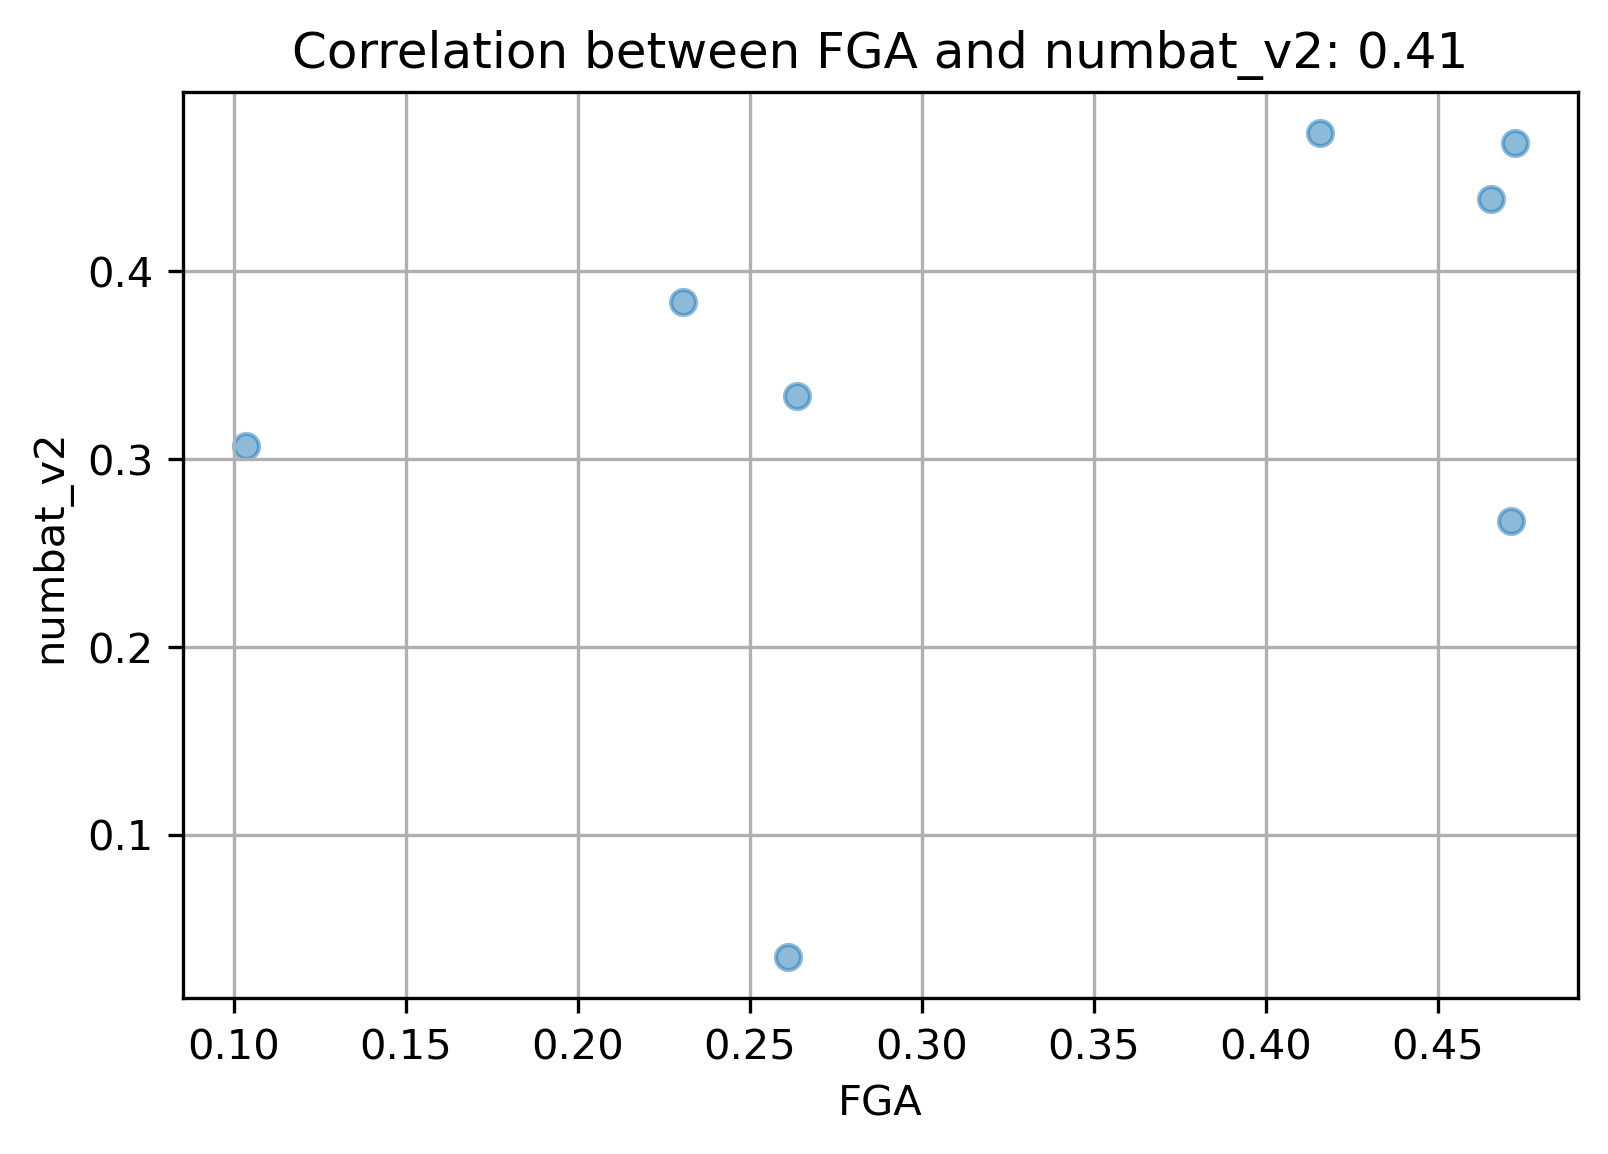

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'column1' and 'column2' are the two columns you want to compare
correlation_coefficient = df['FGA'].corr(df['numbat_v2'])

# Plotting the scatter plot
plt.scatter(df['FGA'], df['numbat_v2'], alpha=0.5)
plt.title(f'Correlation between FGA and numbat_v2: {correlation_coefficient:.2f}')
plt.xlabel('FGA')
plt.ylabel('numbat_v2')
plt.grid(True)
plt.show()

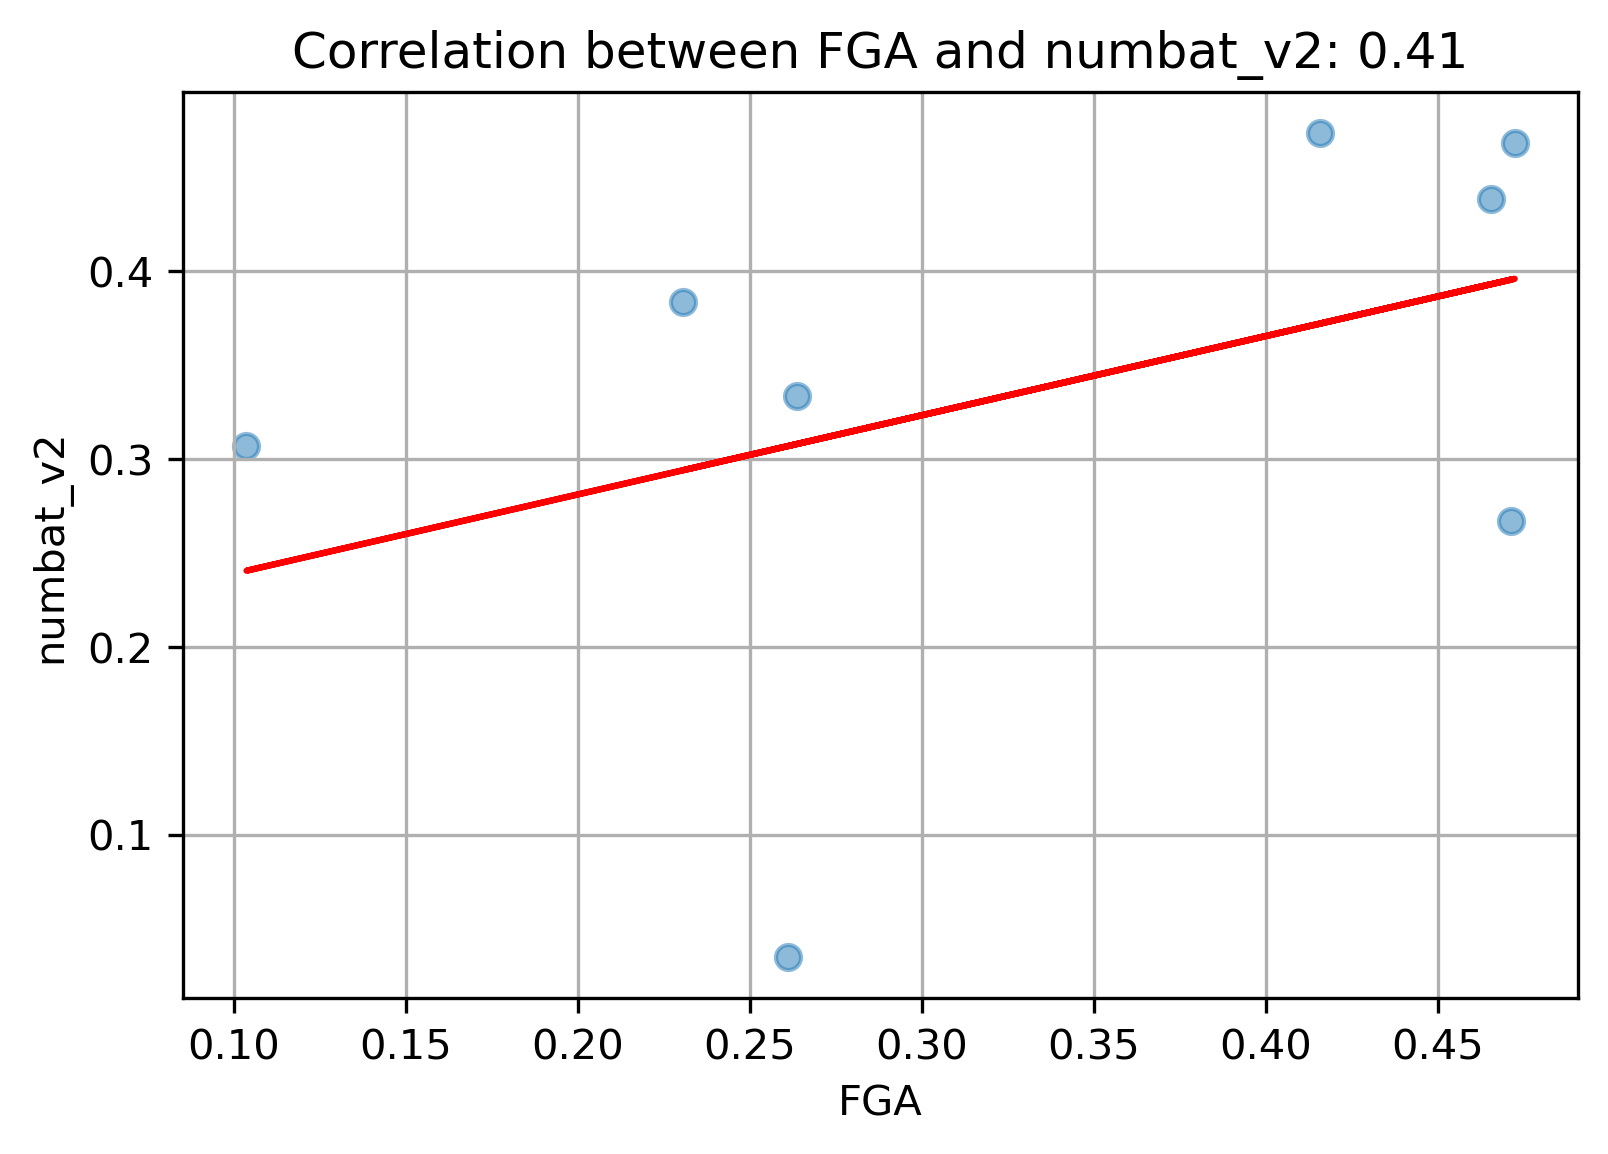

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'column1' and 'column2' are the two columns you want to compare
x = df['FGA']
y = df['numbat_v2']

# Calculate the correlation coefficient
correlation_coefficient = x.corr(y)

slope, intercept = np.polyfit(x, y, 1)

# Create the regression line equation
regression_line = f'y = {slope:.2f}x + {intercept:.2f}'

# Plot the scatter plot


# Plot the regression line
plt.plot(x, slope*x + intercept, color='red', label=regression_line)

# Plotting the scatter plot
plt.scatter(df['FGA'], df['numbat_v2'], alpha=0.5)
plt.title(f'Correlation between FGA and numbat_v2: {correlation_coefficient:.2f}')
plt.xlabel('FGA')
plt.ylabel('numbat_v2')
plt.grid(True)
plt.show()

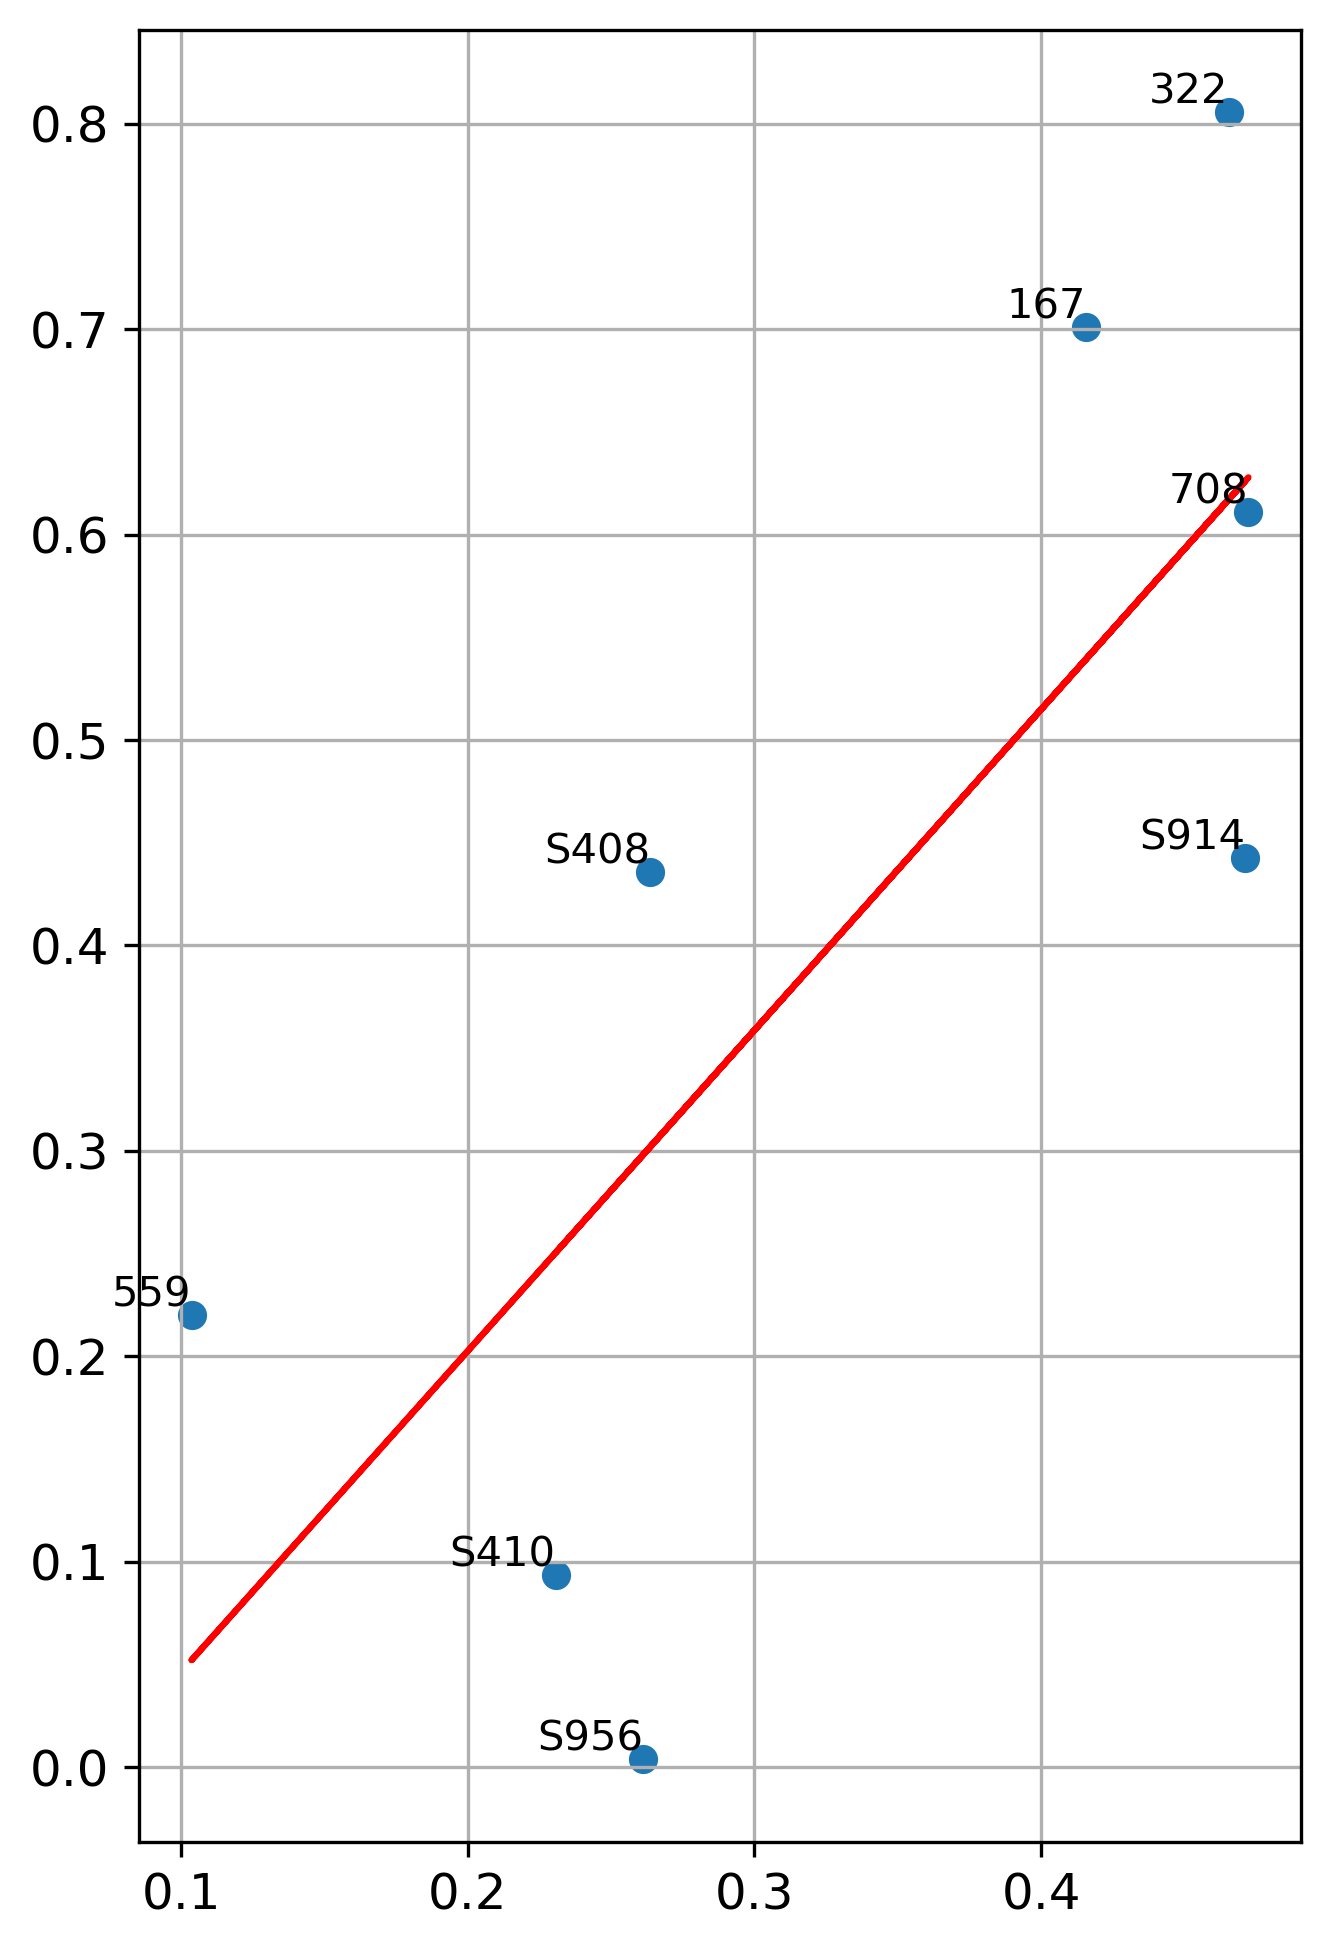

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(5,8))

# Assuming df is your DataFrame and 'column1' and 'column2' are the two columns you want to compare
x = df['FGA']
y = df['numbat_v1']*100

# Calculate the correlation coefficient
correlation_coefficient = x.corr(y)

slope, intercept = np.polyfit(x, y, 1)

# Create the regression line equation
regression_line = f'y = {slope:.2f}x + {intercept:.2f}'

# Plot the scatter plot

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the regression line
plt.plot(x, slope*x + intercept, color='red', label=regression_line)

# Plotting the scatter plot
plt.scatter(x, y)
#plt.title(f'Correlation between WGS and Numbat (Corr Coef: {correlation_coefficient:.3f})')
#plt.xlabel('WGS FGA')
#plt.ylabel('Numbat FGA Approximation')

for i, txt in enumerate(df.index):
    plt.text(x[i], y[i], txt, ha='right', va='bottom')
plt.grid(True)

# Ticks and tick labels with updated font size and family
plt.tick_params(axis='both', which='major', labelsize=12)

# Axis limits and aspect ratio
plt.gca()


#plt.grid(True)
plt.show()

In [79]:
df.index = ['S167', 'S322', 'S559', 'S708', 'S408', 'S410', 'S914', 'S956']

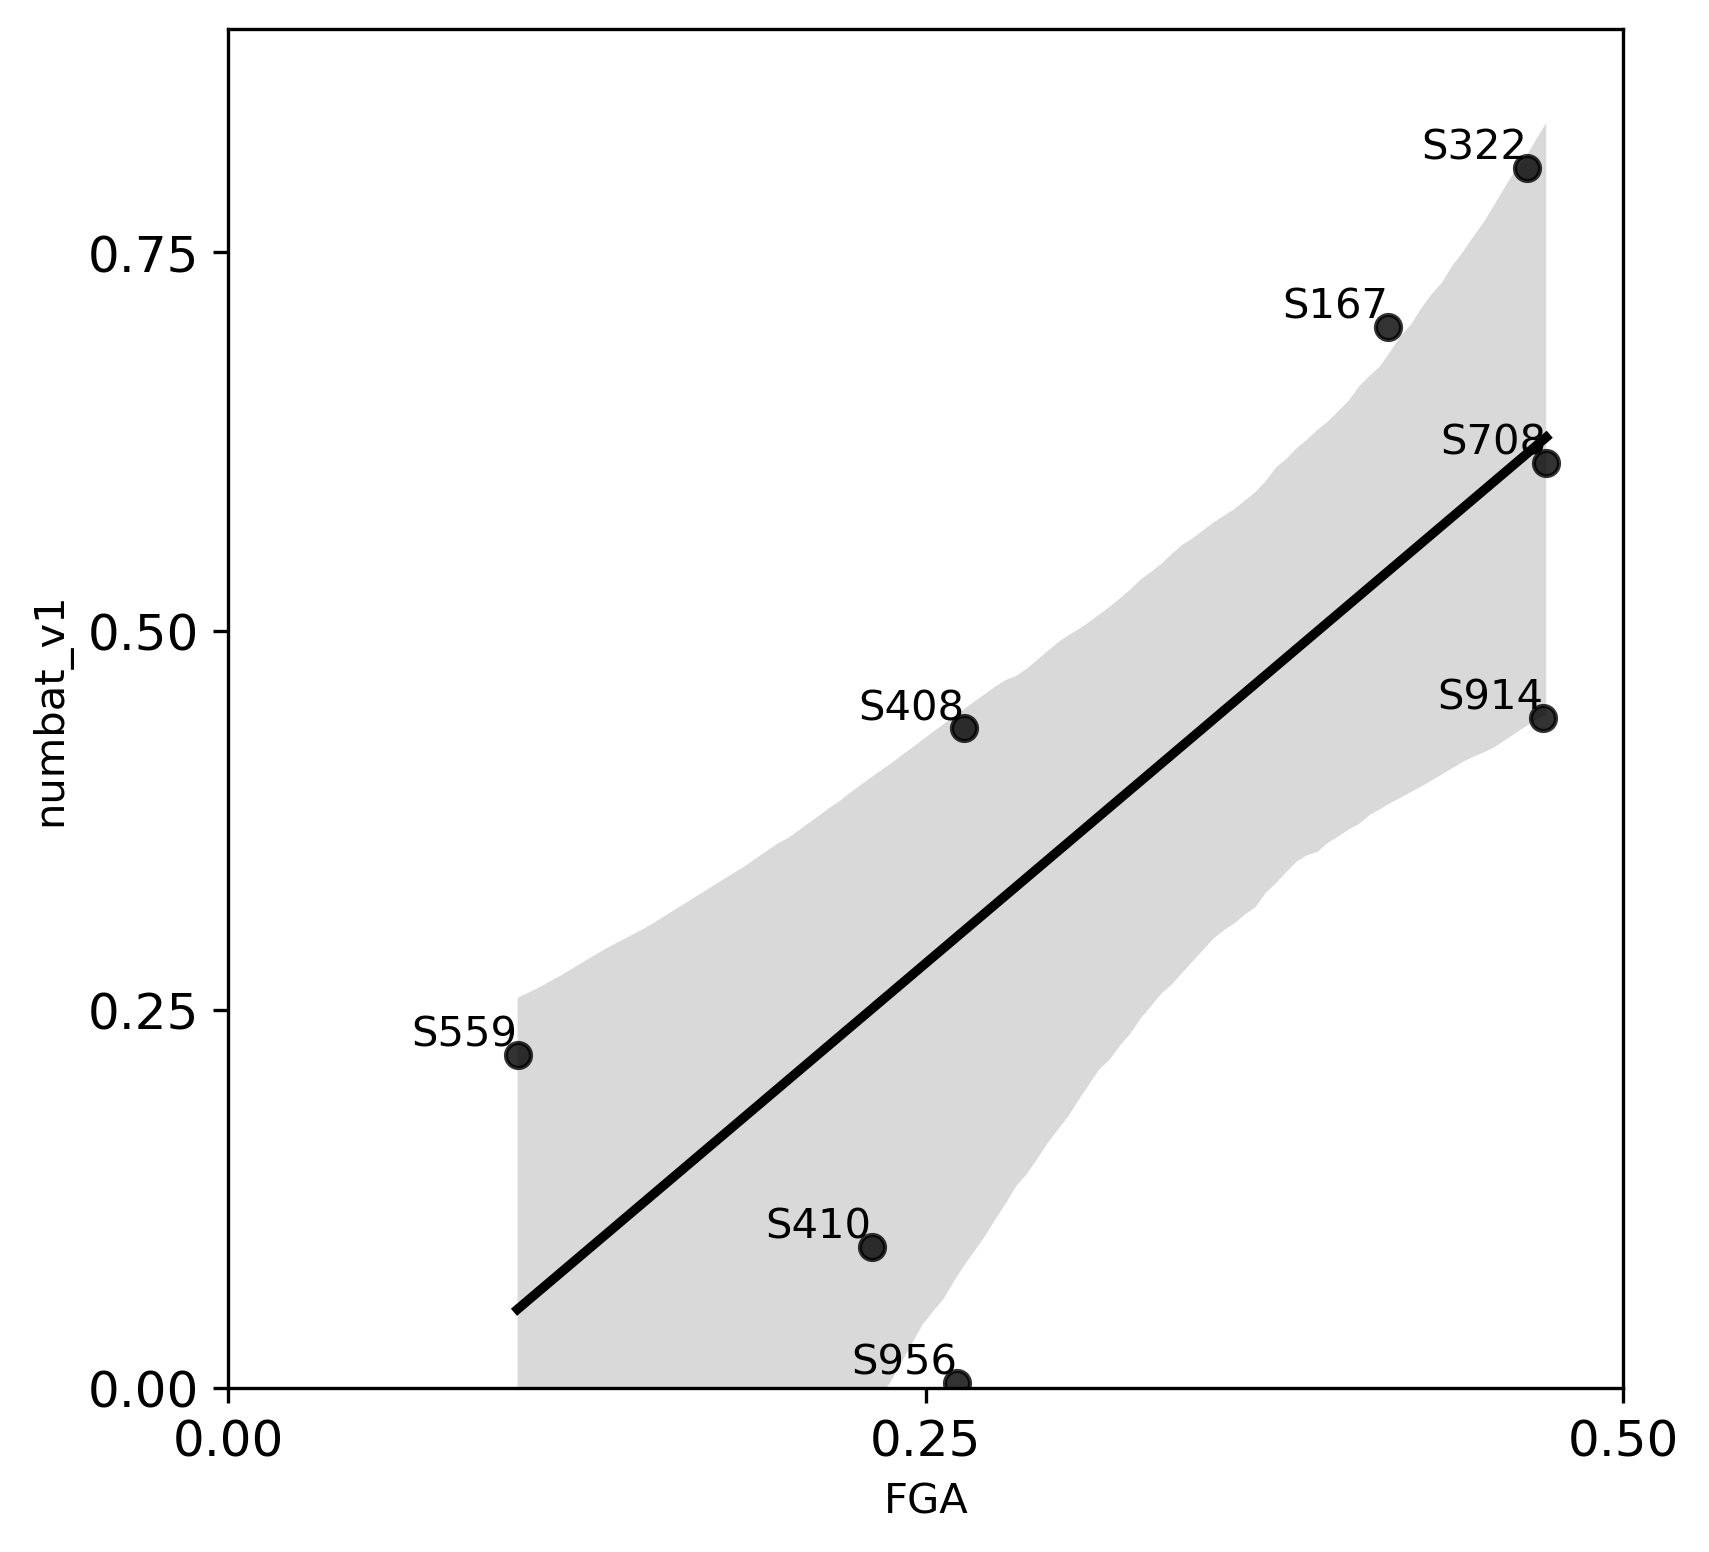

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))  # Adjust the figure size as needed

x = df['FGA']
y = df['numbat_v1'] * 100

# Calculate the correlation coefficient
correlation_coefficient = x.corr(y)

# Fit a linear regression model
sns.regplot(x=x, y=y, ci=95, line_kws={"color": "black"}, scatter_kws={"color": "black"})

# Plotting the scatter plot

# Annotations
for i, txt in enumerate(df.index):
    plt.annotate(txt, (x[i], y[i]), fontsize=10, ha='right', va='bottom')

# Ticks and tick labels with updated font size and sparse ticks
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(np.arange(0, max(x) + 0.1, step=0.25))
plt.yticks(np.arange(0, max(y) + 0.1, step=0.25))

# Set axis limits and aspect ratio
plt.xlim(0)
plt.ylim(0)


# Display the plot
plt.grid(False)
plt.show()


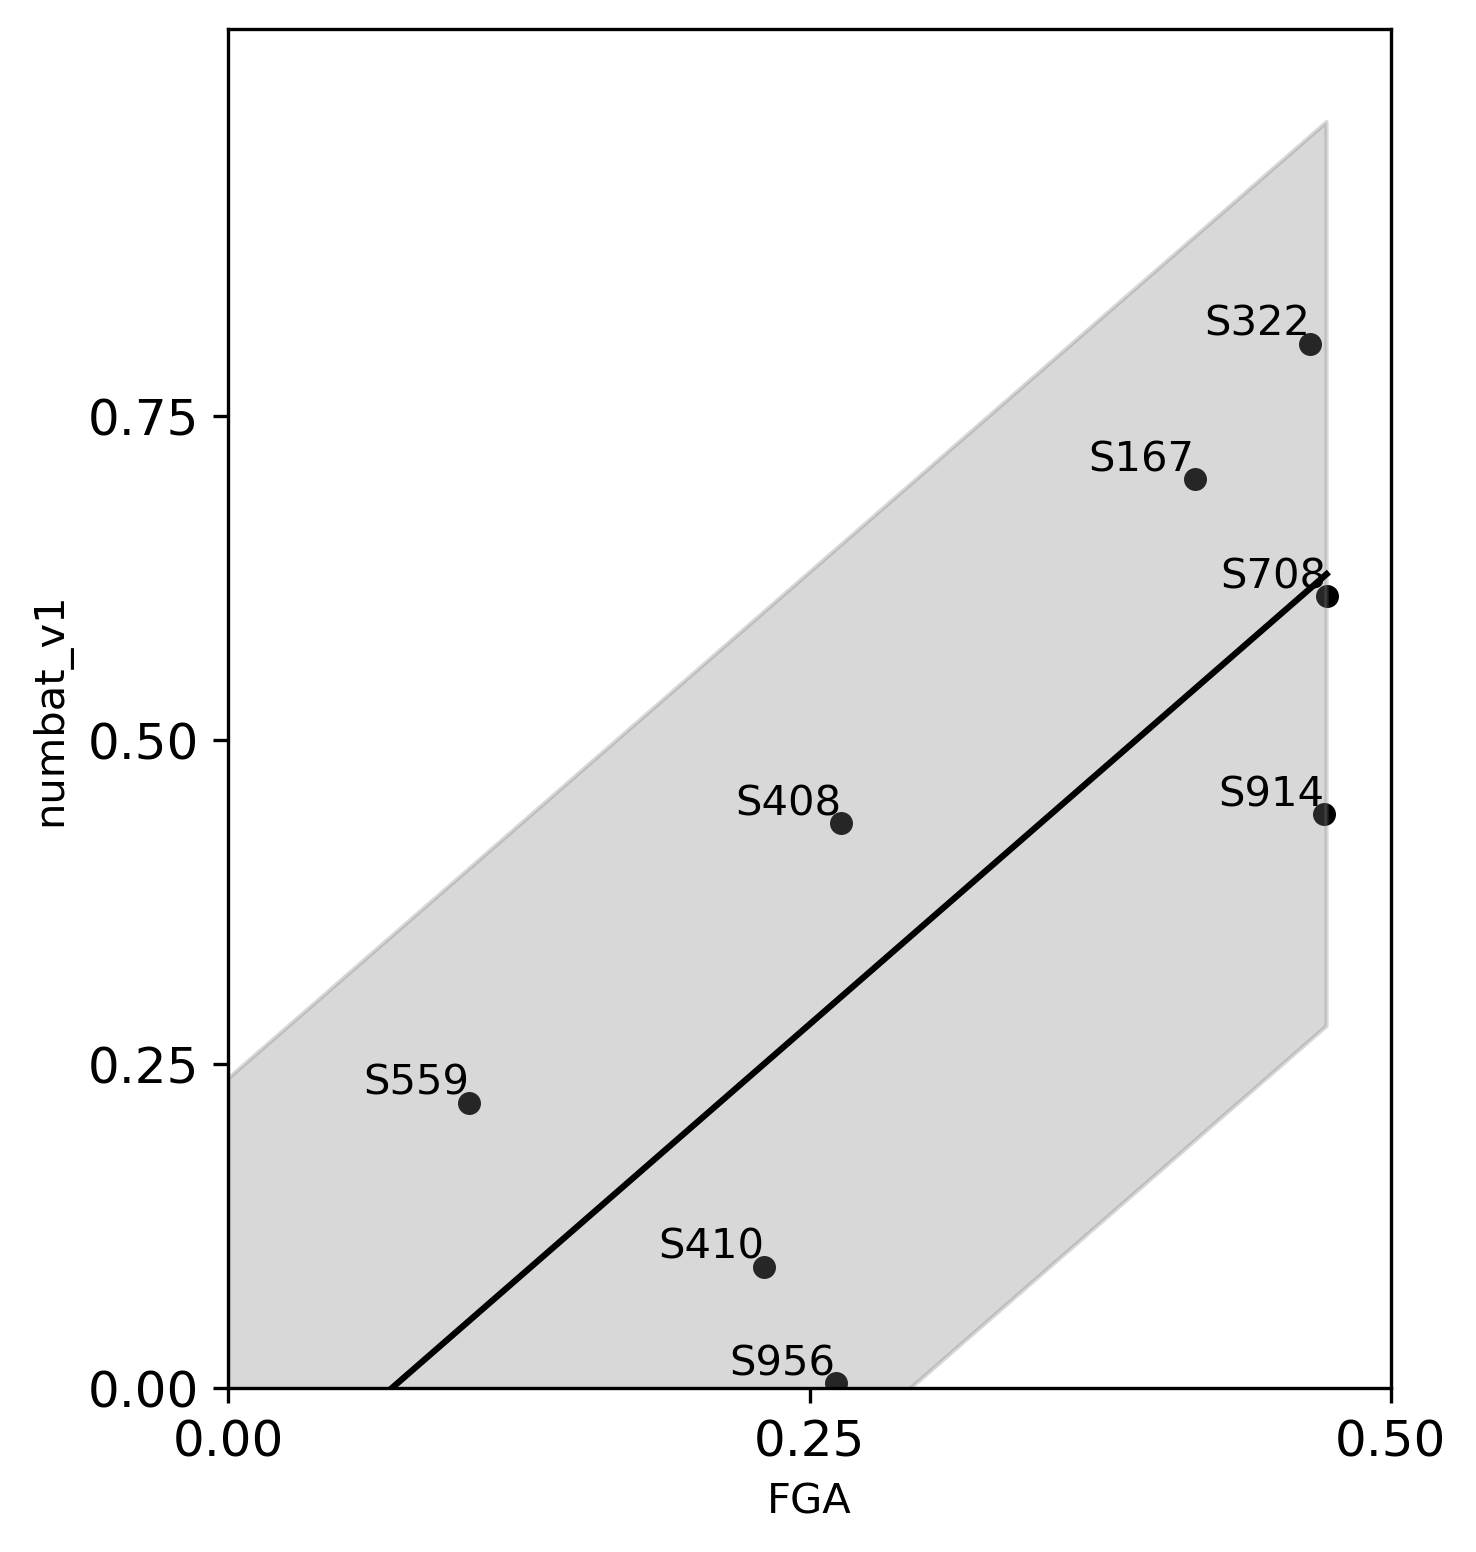

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 6))  # Adjust the figure size as needed

x = df['FGA']
y = df['numbat_v1'] * 100

# Calculate the correlation coefficient
correlation_coefficient = x.corr(y)

# Fit a linear regression model using numpy.polyfit
slope, intercept = np.polyfit(x, y, 1)
regression_line = np.poly1d([slope, intercept])

# Calculate the residuals
residuals = y - regression_line(x)

# Calculate the confidence interval manually
mse = np.mean(residuals**2)
confidence_interval = 1.96 * np.sqrt(mse)  # 95% confidence interval

# Plotting the scatter plot
sns.scatterplot(x=x, y=y, color="black")

# Plot the linear regression line
x_range = np.linspace(0, max(x), 100)
plt.plot(x_range, regression_line(x_range), color="black")

# Plot the confidence interval area
plt.fill_between(x_range, regression_line(x_range) - confidence_interval, regression_line(x_range) + confidence_interval, color='grey', alpha=0.3)

# Annotations
for i, txt in enumerate(df.index):
    plt.annotate(txt, (x[i], y[i]), fontsize=10, ha='right', va='bottom')

# Ticks and tick labels with updated font size and sparse ticks
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(np.arange(0, max(x) + 0.1, step=0.25))
plt.yticks(np.arange(0, max(y) + 0.1, step=0.25))

# Set axis limits and aspect ratio
plt.xlim(0)
plt.ylim(0)

# Display the plot
plt.grid(False)
plt.show()


In [103]:
from scipy.stats import pearsonr

correlation_coefficient, p_value = pearsonr(x, y)
correlation_coefficient, p_value

(0.7530006829865423, 0.031038642845059156)

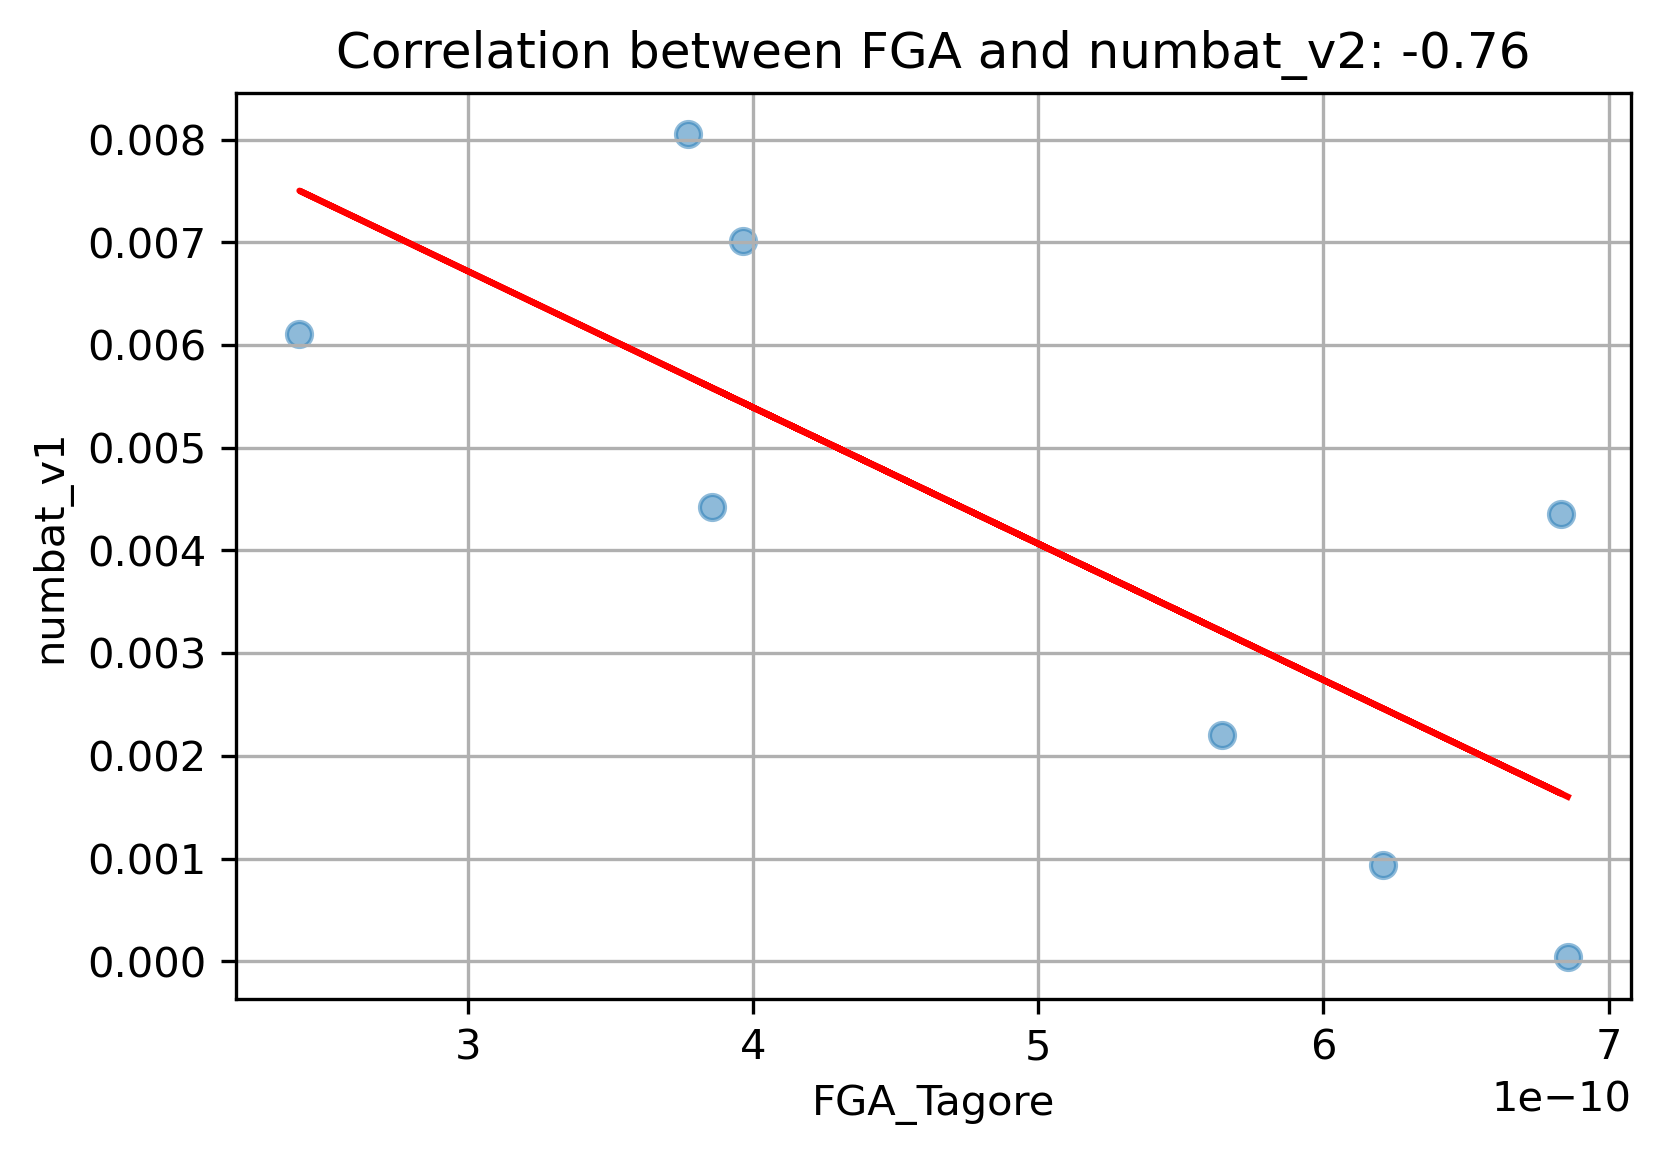

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'column1' and 'column2' are the two columns you want to compare
x = df['FGA_Tagore']
y = df['numbat_v1']

# Calculate the correlation coefficient
correlation_coefficient = x.corr(y)

slope, intercept = np.polyfit(x, y, 1)

# Create the regression line equation
regression_line = f'y = {slope:.2f}x + {intercept:.2f}'

# Plot the scatter plot


# Plot the regression line
plt.plot(x, slope*x + intercept, color='red', label=regression_line)

# Plotting the scatter plot
plt.scatter(x, y, alpha=0.5)
plt.title(f'Correlation between FGA and numbat_v2: {correlation_coefficient:.2f}')
plt.xlabel('FGA_Tagore')
plt.ylabel('numbat_v1')
plt.grid(True)
plt.show()

In [82]:
cons['log_transformed'] = np.log(cons['phi_mle'])
cons

,Unnamed: 0,sample,CHROM,seg,cnv_state,cnv_state_post,seg_start,seg_end,seg_start_index,seg_end_index,...,n_states,cnv_states,p_loh_m1,p_del_m1,p_amp_m1,p_bamp_m1,p_pdel_m1,max,log_transformed,altered
0,1,NaN,1,NaN,neu,neu,778639,248850008,NaN,NaN,...,1,neu,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,False
1,2,NaN,2,NaN,neu,neu,218386,241999784,NaN,NaN,...,1,neu,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,False
2,3,NaN,3,NaN,neu,neu,195758,36826819,NaN,NaN,...,1,neu,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,False
3,4,NaN,3,NaN,neu,neu,36910081,36944173,NaN,NaN,...,1,neu,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,False
4,5,2.0,3,3c,amp,amp,36975462,78774362,11514.0,13388.0,...,0,amp,2.816813e-07,1.086157e-12,0.000034,2.069806e-24,6.579456e-32,0.000034,0.383311,True
5,6,NaN,3,NaN,neu,neu,78777671,197960200,NaN,NaN,...,1,neu,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,False
6,7,NaN,4,NaN,neu,neu,53285,190173774,NaN,NaN,...,1,neu,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,False
7,8,NaN,5,NaN,neu,neu,113462,181261212,NaN,NaN,...,1,neu,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,False
8,9,NaN,6,NaN,neu,neu,292057,170577443,NaN,NaN,...,1,neu,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,False
9,10,NaN,7,NaN,neu,neu,190049,159028175,NaN,NaN,...,1,neu,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,False


In [13]:
cons["max"].sum()

3.688169604554677e-05

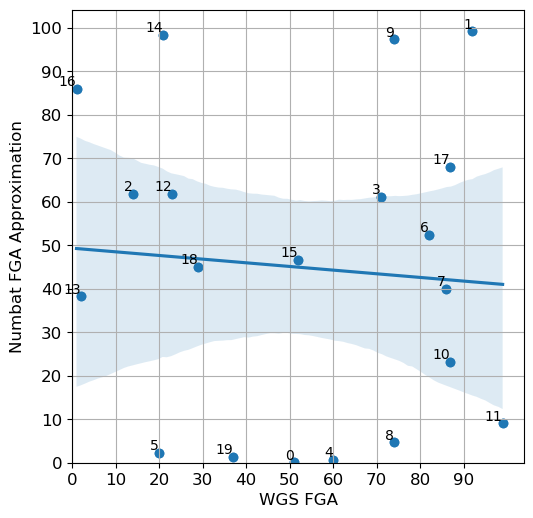

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data generation (replace this with your DataFrame)
np.random.seed(42)
df = pd.DataFrame({'FGA': np.random.randint(0, 100, 20),
                   'numbat_v1': np.random.rand(20)})

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Assuming df is your DataFrame and 'column1' and 'column2' are the two columns you want to compare
x = df['FGA']
y = df['numbat_v1'] * 100

# Calculate the correlation coefficient
correlation_coefficient = x.corr(y)

# Fit a linear regression model
sns.regplot(x=x, y=y, ci=95)  # ci parameter sets confidence interval

# Plotting the scatter plot
plt.scatter(x, y)
plt.xlabel('WGS FGA', fontsize=12)
plt.ylabel('Numbat FGA Approximation', fontsize=12)

# Annotations
for i, txt in enumerate(df.index):
    plt.annotate(txt, (x[i], y[i]), fontsize=10, ha='right', va='bottom')

# Ticks and tick labels with updated font size and sparse ticks
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(np.arange(0, max(x) + 1, step=10))
plt.yticks(np.arange(0, max(y) + 1, step=10))

# Set axis limits and aspect ratio
plt.xlim(0)
plt.ylim(0)
plt.gca().set_aspect('equal', adjustable='box')

# Display the plot
plt.grid(True)
plt.show()
